# Lecture 1: Girvan-Newman and the Modularity

In [1]:
import numpy as np
import networkx as nx 

In [2]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt

## Load the Zachary Karate Club dataset and create the graph

In [3]:
z_ed=np.genfromtxt('../Data/zachary.txt', skip_header=2, dtype='i8')-1

In [4]:
G=nx.Graph()
G.add_edges_from(z_ed)

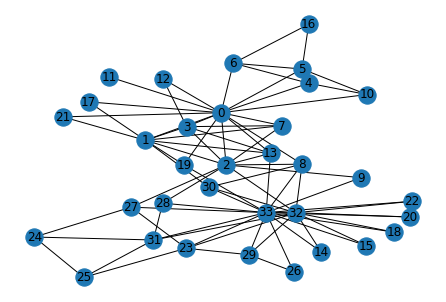

In [37]:
pos=nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True)

## Girvan-Newman

### Naively, the philosophy

In [6]:
ebc=nx.edge_betweenness_centrality(G)

In [7]:
ebc

{(0, 1): 0.025252525252525245,
 (0, 2): 0.07778768072885714,
 (0, 3): 0.02049910873440285,
 (0, 4): 0.0522875816993464,
 (0, 5): 0.07813428401663694,
 (0, 6): 0.07813428401663695,
 (0, 7): 0.0228206434088787,
 (0, 8): 0.07423959482783014,
 (0, 10): 0.0522875816993464,
 (0, 11): 0.058823529411764705,
 (0, 12): 0.04652406417112298,
 (0, 13): 0.042371898254251195,
 (0, 17): 0.04012392835922249,
 (0, 19): 0.045936960642843,
 (0, 21): 0.04012392835922249,
 (0, 31): 0.12725999490705367,
 (1, 2): 0.023232323232323233,
 (1, 3): 0.0077243018419489,
 (1, 7): 0.007422969187675069,
 (1, 13): 0.01240556828792123,
 (1, 17): 0.018699601052542227,
 (1, 19): 0.014633732280791106,
 (1, 21): 0.018699601052542227,
 (1, 30): 0.032280791104320514,
 (2, 3): 0.022430184194890075,
 (2, 7): 0.025214328155504617,
 (2, 8): 0.009175791528732704,
 (2, 9): 0.030803836686189627,
 (2, 13): 0.007630931160342923,
 (2, 27): 0.04119203236850296,
 (2, 28): 0.02278244631185807,
 (2, 32): 0.06898678663384547,
 (3, 7): 0.0033

In [8]:
nx.number_connected_components(G)

1

In [9]:
ebc_a=np.array(list(ebc.values()))

In [10]:
where_max=np.where(ebc_a==np.max(ebc_a))[0]

In [11]:
where_max

array([15])

In [12]:
len(where_max)>1

False

In [13]:
selected_edge=list(ebc.keys())[where_max[0]]

In [14]:
G.remove_edge(selected_edge[0], selected_edge[1])

In [15]:
np.random.randint(42)

23

### Routines

In [16]:
def GN_one_step(G):
    ebc=nx.edge_betweenness_centrality(G)
    ebc_a=np.array(list(ebc.values()))
    where_max=np.where(ebc_a==np.max(ebc_a))[0]
    lwm=len(where_max)
    if lwm==1:
        selected_edge=list(ebc.keys())[where_max[0]]
    else:
        who=np.random.randint(lwm)
        selected_edge=list(ebc.keys())[where_max[who]]
    G.remove_edge(selected_edge[0], selected_edge[1])
    ncc=nx.number_connected_components(G)
    cc=nx.connected_components(G)
    return G, ncc, cc, selected_edge

In [17]:
def GN(G):
    _G=G.copy()
    co_dict={}
    l_nodes=len(_G.nodes)
    ncc_0=1
    _G, ncc, cc, selected_edge=GN_one_step(_G)
    while ncc<l_nodes:
        if ncc_0<ncc:
            co_dict[ncc]=list(cc)
            ncc_0=ncc
        _G, ncc, cc, selected_edge=GN_one_step(_G)
    return co_dict

In [18]:
colors=['dodgerblue','maroon', 'teal','darkorange', 'blue', 'indigo', 'darkmagenta']

In [19]:
%timeit GN(G)

117 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
G_gn=GN(G)

In [21]:
pos=nx.kamada_kawai_layout(G)

### SuperMegaPlot

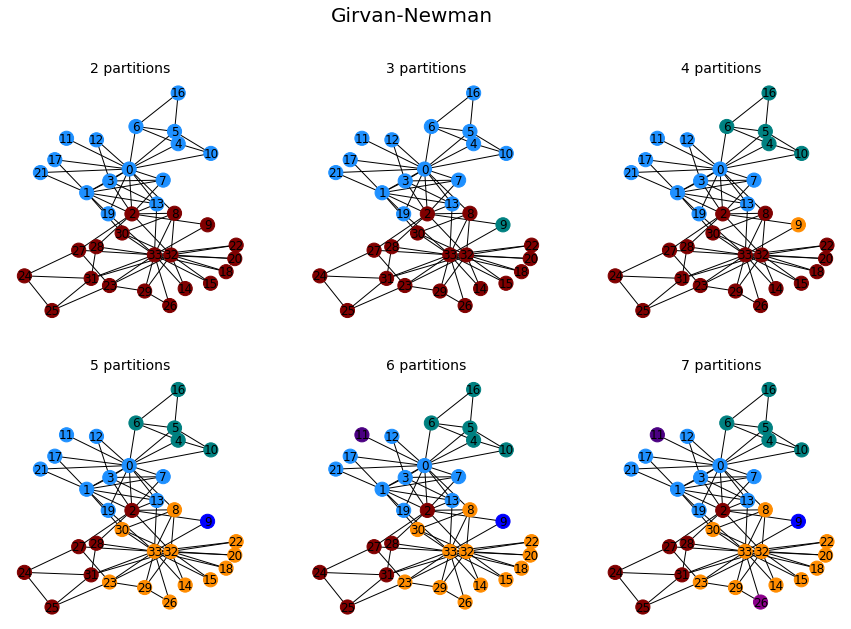

In [32]:
#plt.figure(figsize=(10, 10))
fig, ax_lst = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle('Girvan-Newman', fontsize=20)
fig.patch.set_visible(False)
# cancel the frame
for t in range(2,2+6):
    x=(t-2)//3
    y=(t-2)%3
    ax_lst[x,y].set_title(str(t)+' partitions', fontsize=14)
    nx.draw_networkx_edges(G, pos, ax=ax_lst[x, y])
    
    gn_dict=G_gn[t]
    memb=np.zeros(len(G.nodes), dtype='i8')
    for i_t in range(t):
        
        for gndi in list(gn_dict[i_t]):
            memb[gndi]=i_t
    rgb=[colors[m] for m in memb]
    
    nx.draw_networkx_nodes(G, pos, range(len(memb)), node_size = 200, node_color =rgb, ax=ax_lst[x, y])
    nx.draw_networkx_labels(G, pos, ax=ax_lst[x, y])
    ax_lst[x, y].axis('off')
    # cancel the frame
plt.show()

Where should I stop? Modularity!

In [50]:
%timeit dict(G.degree)

10 µs ± 12.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [51]:
%timeit np.unique(z_ed, return_counts=True)

18.1 µs ± 67.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Actually, sometimes numpy is slower, but it has a lot of non trivial functions otherwise complicate to implement from zero. For the degree sequence we are going to use dictionaries, but for the adjacency list we will follow a mixed strategy...

In [53]:
deg_dict=dict(G.degree)

In [58]:
m=sum(deg_dict.values())//2

In [99]:
adl_dict={}
for i in range(np.max(z_ed)+1):
    buddies=np.where(z_ed==i)
    adl_dict[i]=np.array([z_ed[buddies[0][b], int(not buddies[1][b])] for b in range(len(buddies[0]))])

### Modularity

In [110]:
def modularity_ij(dict_deg, dict_adl, node_i, node_j, m):
    a_ij=int(node_j in dict_adl[node_i])
    return (a_ij-dict_deg[node_i]*dict_deg[node_j]/(2*m))/m

In [114]:
def modularity_memb(memb, dict_deg, dict_adl, m):
    Q=0
    comms=np.unique(memb)
    for c in comms:
        where_c=np.where(memb==c)[0]
        l_wc=len(where_c)
        for i_wc in range(l_wc-1):
            for j_wc in range(i_wc+1, l_wc):
                Q+=modularity_ij(dict_deg, dict_adl, i_wc, j_wc, m)
    return Q

### The new SuperMegaPlot

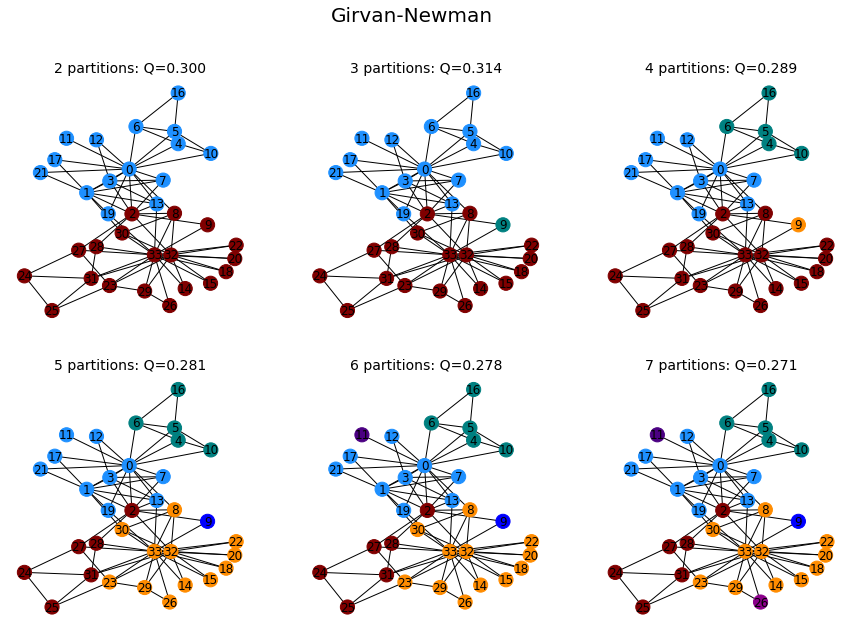

In [121]:
fig, ax_lst = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle('Girvan-Newman', fontsize=20)
fig.patch.set_visible(False)
# cancel the frame
for t in range(2,2+6):
    x=(t-2)//3
    y=(t-2)%3
    
    nx.draw_networkx_edges(G, pos, ax=ax_lst[x, y])
    
    gn_dict=G_gn[t]
    memb=np.zeros(len(G.nodes), dtype='i8')
    for i_t in range(t):
        
        for gndi in list(gn_dict[i_t]):
            memb[gndi]=i_t
    rgb=[colors[m] for m in memb]
    
    nx.draw_networkx_nodes(G, pos, range(len(memb)), node_size = 200, node_color =rgb, ax=ax_lst[x, y])
    nx.draw_networkx_labels(G, pos, ax=ax_lst[x, y])
    Q=modularity_memb(memb, deg_dict, adl_dict, m)
    ax_lst[x,y].set_title('{0:d} partitions: Q={1:.3f}'.format(t, Q), fontsize=14)
    ax_lst[x, y].axis('off')
    # cancel the frame
plt.show()

### Reinventing the wheel again...

In [122]:
from networkx.algorithms.community.centrality import girvan_newman as gn

In [124]:
%timeit GN(G)

118 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [125]:
%timeit gn(G)

236 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Quite faster… O.O